## 5. Állandó fázisú pont módszere, SPPMethod

Ez a módszer alapjaiban kissé különbözik a többitől. Az előzőleg leírt globális metódusok, mint domain átváltás, kivágás, stb. itt is működnek, de másképpen kell kezelni őket. *Megjegyezném, hogy mivel ez a módszer interaktív elemet tartalmaz, az egyelőre csak Jupyter Notebook-ban stabil.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysprint as ps

Példaként a korábban már bemutatott `ps.Generator` segítségével generálni fogok egy sorozat interferogramot, majd azon bemutatom a kiértékelés menetét. Valós méréseknél teljesen hasonlóképpen végezhető a kiértékelés. A legegyszerűbb módszer, hogy különböző karok közti időbeli késleltetésnél generáljunk és elmentsük azokat az alábbi cellában látható. A megkülönböztethetőség miatt minden fájlt a hozzá tartozó karok közti időbeli késleltetésnek megfelelően nevezem el.

In [9]:
for delay in range(-200, 201, 50):
    g = ps.Generator(1, 3, 2, delay, GDD=400, TOD=-500, normalize=True)
    g.generate_freq()
    np.savetxt(f'{delay}.txt', np.transpose([g.x, g.y]), delimiter=',')

A kód lefuttatásával a munkafüzet környtárában megjelent 7 új txt fájl. 

Ehhez a kiértékelési módszerhez először fel kell építeni egy listát a felhasználandó interferogramok fájlneveivel. Ezt manuálisan is megtehetjük, itt ezt elkerülve egy rövidítést fogok használni.

In [10]:
ifg_files = [f"{delay}.txt" for delay in range(-200, 201, 50)]

In [11]:
print(ifg_files)

['-200.txt', '-150.txt', '-100.txt', '-50.txt', '0.txt', '50.txt', '100.txt', '150.txt', '200.txt']


Ha nem hasonló sémára épülnek a felhasználandó fájlok nevei, akkor természetesen a fenti trükk nem működik és egyenként kell beírnunk őket. Miután definiáltuk a fájlneveket a következő lépés a
```python
ps.SPPMethod(ifg_names, sam_names=None, ref_names=None, **kwargs)
```
meghívása:

In [12]:
myspp = ps.SPPMethod(ifg_files, decimal=".", sep=",", skiprows=0, meta_len=0)

A `**kwargs` keyword argumentumok itt elfogadják a korábban már bemutatott `parse_raw` funkció argumentumait (a kódban belül azt is hívja meg egyesével minden interferogramon), hiszen a fájlok sémáját itt is fontos megadni a helyes betöltéshez. A tárgy- és referencianyaláb spektrumai természetesen opcionális argumentumok, mi dönthetjük el, hogy normáljuk-e az interferogramokat.

Az `SPPMethod` objektum először ellenőrzi, hogy a listában lévő fájlnevek valóban léteznek-e, és ha nem, akkor hibával tér vissza. Az `SPPMethod`-nak vannak további metódusai, ilyen pl. a `len(..)`, vagy az `SPPMethod.info`. Az első visszaadja, hogy hány interferogram van jelenleg az objektumban (ez jelen esetben 9), a második pedig a kiértékelés során mutatja majd, hogy hány interferogramból rögzítettünk információt (ez jelenleg 0/9). Később talán `append` (ilyen már van a 0.12.5 verziótól), `insert` és `delete` metódusokat is beépítek.

In [13]:
print(len(myspp))

9


In [14]:
print(myspp.info)

Progress: 0/9


Az SPPMethod objektum listaszerűen viselkedik: lehet indexelni is. Mivel benne 9 darab interferogram van, ezért egy ilyen indexelés egy `ps.Dataset` objektumot ad vissza. Ez az alapja minden kiértékelési módszernek, így ez ismeri a korábban bemutatott metódusokat. Tegyük fel, hogy a 3. interferogram adatait ki szeretnénk iratni, és szeretnénk megkapni az y értékeit `np.ndarray`-ként. Ekkor a 2 indexet használva (mivel itt is 0-tól indul a számozás):

In [15]:
# a harmadik interferogram adatainak kiíratása
print(myspp[2])

Dataset
----------
Parameters
----------
Datapoints: 12559
Predicted domain: frequency
Range: from 0.99998 to 3.00000 PHz
Normalized: False
Delay value: Not given
SPP position(s): Not given
----------------------------
Metadata extracted from file
----------------------------
{}


In [16]:
# a harmadik interferogram y értékeinek kinyerése, mint np.array
y_ertekek = myspp[2].data.y.values
print(y_ertekek)
print(type(y_ertekek))

[4.22567237e-08 4.23424876e-08 4.24102757e-08 ... 4.41394357e-08
 4.30227521e-08 4.18888151e-08]
<class 'numpy.ndarray'>


Újra hangsúlyozom, minden eddig bemutatott metódus ezeken a kvázi listaelemeken is működik, köztük a `chdomain`, vagy `slice` is. Ezt használjuk ki a kiértékeléshez egy *for* ciklusban. A kiértékeléshez a definiált `SPPMethod`-on meg kell hívni egy for ciklust. Ez végigfut a benne lévő összes interferogramon. Azt, hogy mit akarunk csinálni adott interferogrammal, azt a cikluson belül tudjuk megadni. Az alapvető séma a következő:
<pre>
for ifg in myspp:
    - előfeldolgozása az adott interferogramnak
    - az interaktív SPP Panel megnyitása és adatok rögzítése
    
- a calculate metódus meghívása a cikluson kívül(!)
</pre>

Ez kód formájában az alábbi cellában látható. Itt külön jelöltem, hogy melyik rész meddig tart.

In [17]:
# az interaktív számításokat fontos a with blokkon belülre írni

with ps.interactive():

    for ifg in myspp:

        # -----------------------------------Előfeldolgozás-----------------------------------------
        # Ha valós mérésünk van, érdemes valamilyen módon kiíratni a kommentet,
        # ami az interferogram fájlban van, hogy meg tudjuk állapítani milyen késleltetésnél készült.
        # Jelen esetben ennek nincs értelme, mivel a szimulált fájlokkal dolgozom.
        # Ezt legegyszerűbben az alábbi sorral tehetnénk meg: 
        # print(ifg.meta['comment'])
        # vagy esetleg a teljes metaadatok kiíratása:
        # print(ifg.meta)

        # Ha hullámhossztartományban vagyunk, először át kell váltani.
        # Én frekvenciatartományban szimuláltam, ezért itt kihagyom. Ha szükség van rá a
        # következő sort kell használni.
        # ifg.chdomain() 

        # Pl. 1.2 PHz alatti körfrekvenciaértékek kivágása. Mivel nem adtam meg stop értéket, így a felső
        # határt érintetlenül hagyná, ha futtatnám. Nyilván ez is opcionális.
        # ifg.slice(start=1.2)

        # -----------------------------Az interaktív panel megnyitása-------------------------------
        ifg.open_SPP_panel()

# ---------------------------------A ciklus utáni rész------------------------------------------
# A cikluson kívül a save_data metódus meghívása, hogy elmentsük a beírt adatainkat fájlba is.
# Ez természetesen opcionális, de annak érdekében, hogy biztosan ne veszítsünk adatot érdemes ezt is elvégezni.
myspp.save_data('spp.txt')


# a cikluson kívül meghívjuk a calculate függvényt
myspp.calculate(reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A magyarázatok nélkül szimulált esetben az egész kód az alábbi, összesen 8 sorra egyszerűsödik. Valós mérés esetén néhány előfeldolgozási lépés és kiíratás természetesen még hozzáadódhat ehhez.

```python
import pysprint as ps

ifg_files = [f"{delay}.txt" for delay in range(-200, 201, 50)]

s = ps.SPPMethod(ifg_files, decimal=".", sep=",", skiprows=0, meta_len=0)

with ps.interactive():
    for ifg in s:
        ifg.open_SPP_panel()
    
s.save_data('spp.txt')
s.calculate(reference_point=2, order=2, show_graph=True)
```
Miután a számolást már elvégezte a program, akkor elérhetővé válik rajta a `GD` property. Ez az illesztett görbét reprezentálja, típusa `ps.core.phase.Phase`. Bővebben erről a `Phase` leírásában.

In [18]:
myspp.GD

#### 5.1 Számolás nyers adatokból
Mivel az `spp.txt` fájlba elmentettük az bevitt adatokat, azokból egyszerűen lehet újraszámolni az illesztést. Töltsük be `np.loadtxt` segítségével, majd használjuk a `ps.SPPMethod.calculate_from_raw` függvényt.

In [19]:
delay, position = np.loadtxt('spp.txt', delimiter=',', unpack=True)

myspp.calculate_from_raw(delay, position, reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Az előbbi esetben látható, hogy ugyan azt az eredményt kaptuk, mint előzőleg. Ez akkor is hasznos lehet, ha már megvannak a leolvasott SPP pozícióink a hozzá tartozó késleltetésekkel és csak a számolást akarjuk elvégezni. Ekkor még létre sem kell hozni egy új objektumot, csak meghívhatjuk a függvényt következő módon:


In [20]:
# ehhez beírtam egy teljesen véletlenszerű adatsort
delay_minta = [-100, 200, 500, 700, 900]
position_minta = [2, 2.1, 2.3, 2.45, 2.6]

ps.SPPMethod.calculate_from_raw(delay_minta, position_minta, reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**FONTOS MEGJEGYZÉS:**

Az `order` argumentum a program során mindig a keresett diszperzió rendjét adja meg.

#### 5.2 Számolás egy további módon

Mivel továbbra is ugyan ezekkel az adatsorokkal és a `myspp` objektummal dolgozom, most törlöm az összes rögzített adatot belőlük. Ehhez a `SPPMethod.flush` függvényt használom. (Valószínűleg ez a felhasználónak kevésszer szükséges, de elérhető.)

In [21]:
myspp.flush()

Korábban már észrevehettük, hogy a kiíratás során - legyen bármilyen módszerről is szó - megjelentek olyan sorok is, hogy `Delay value: Not given` és `SPP position(s): Not given`. Például a `myspp` első interferogramja esetén most ez a helyzet:

In [22]:
print(myspp[0])

Dataset
----------
Parameters
----------
Datapoints: 12559
Predicted domain: frequency
Range: from 0.99998 to 3.00000 PHz
Normalized: False
Delay value: Not given
SPP position(s): Not given
----------------------------
Metadata extracted from file
----------------------------
{}


Ahogyan a `Dataset` leírásában már szerepelt, lehetőségünk van megadni a betöltött interferogramokon az SPP módszerhez szükséges adatokat. Ekkor a `ps.SPPMethod.calculate_from_ifg(ifgs, reference_point, order)` függvénnyel kiértékelhetjük a benne lévő interferogramokat a következő módon:

In [23]:
# kicsomagolok öt interferogramot a generált 7 közül

elso_ifg = myspp[0]
masodik_ifg = myspp[1]
harmadik_ifg = myspp[2]
negyedik_ifg = myspp[3]
otodik_ifg = myspp[4]

In [24]:
# beállítok rájuk véletlenszerűen SPP adatokat

elso_ifg.delay = 0
elso_ifg.positions = 2

masodik_ifg.delay = 100
masodik_ifg.positions = 2

harmadik_ifg.delay = 150
harmadik_ifg.positions = 1.6

negyedik_ifg.delay = 200
negyedik_ifg.positions = 1.2

otodik_ifg.delay = 250
otodik_ifg.positions = 1, 3, 1.2


# listába teszem őket
ifgs = [elso_ifg, masodik_ifg, harmadik_ifg, negyedik_ifg, otodik_ifg]

In [25]:
# meghívom a calculate_from_ifg függvényt
ps.SPPMethod.calculate_from_ifg(ifgs, reference_point=2, order=3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Ez úgy lehet hasznos, hogy amikor más módszerrel több interferogramot is kiértékelünk egymás után, csak rögzítjük az SPP adatokat is, aztán a program ezekből egyenként összegyűjti a szükséges információt a kiértékeléshez, majd abból számol.

#### 5.3 Az SPPMethod működéséről mélyebben, cache, callbacks, from_log


Az `SPPMethod` alapvető működését az adatok rögzítése közben az alábbi ábra mutatja.

![SPP működése](spp_diagram.svg)

A hurok az `SPPMethod`-ból indul, ahol a használandó fájlok neveit, betöltési adatokat, stb. adunk meg. Ezen a ponton még semmilyen számolás és betöltés nem történik. Ezután az `SPPMethod` bármely elemének hívására egy `Dataset` objektum jön létre. Ezen megnyitható az `SPPEditor`, amiben az állandó fázisú pont(ok) helyét és a karok közti késleltetést lehet megadni. Hitelesítés után az SPP-vel kapcsolatos információk az interaktív szerkesztőből visszakerülnek a létrehozott `Dataset` objektumba és ott rögzítődnek. Minden így létrejött `Dataset` objektum kapcsolva van az `SPPMethod`-hoz, amiből felépült, így amikor megváltozik egy SPP-vel kapcsolatos adat, az egyből megváltozik az `SPPMetod`-ban is. A `Registry` gondoskodik arról, hogy minden objektum ami a memóriában van az rögzítődjön, illetve szükség esetén elérhető legyen.


**Cache**

Ha próbálunk elérni egy adott elemet (akár a `for` ciklussal, akár indexelve, vagy egyéb módon), létrejön egy `Dataset` objektum. Ez a `Dataset` objektum miután már egyszer elértük a memóriában marad és megtart minden rajta végrehajtott változtatást, beállítást. Alapértelmezetten *128 db* interferogram marad a memóriában egyszerre, de ez a határ szükség esetén megváltoztatható. Az éppen aktuálisan a memóriában lévő interferogramok száma (az adott `SPPMethod`-hoz tartozó) a kiíratás során a `Interferograms cached` cellában látható.

**Callbacks**

A fenti ábrán a ciklus utolsó lépése során (ahol a `Dataset` átadja az SPP-vel kapcsolatos adatait a `SPPMethod`-nak) lehetőség van további ún. *callback* függvények meghívására. Egy ilyen beépített callback függvény a `pysprint.eager_executor`. Ez arra használható, hogy minden egyes SPP-vel kapcsolatos adat rögzítése/változtatása után a program azonnal kiszámolja az éppen meglévő adatokból a diszperziót. A korábbiakhoz teljesen hasonlóan kell eljárnunk, csupán a `callback` argumentumot kell megadnunk kiegészítésként. Itt a kötelező argumentumokon túl megadtam a `logfile` és `verbosity` értékeit is: ez minden lépés során a `"mylog.log"` fájlba el fogja menteni az adott illesztés eredményeit és egyéb információkat, továbbá a `verbosity=1` miatt a rögzített adatsort is. Ezzel akár könnyen nyomon követhető a kiértékelés menete.

In [27]:
# a folyamatos kiértékeléshez szükséges callback függvény importálása
from pysprint import eager_executor

myspp2 = ps.SPPMethod(
    ifg_files,
    decimal=".",
    sep=",",
    skiprows=0,
    meta_len=0,
    callback=eager_executor(reference_point=2, order=3, logfile="mylog.log", verbosity=1)
)

In [28]:
myspp2

Ekkor láthatjuk, hogy az `Eagerly calculating` már `True` értékre változik.

Természetesen a program csak értelmes esetekben fogja elvégezni a számolást (pl. szükséges, hogy az adatpontok száma nagyobb legyen, mint az illesztés rendje ). A teljesség kedvéért megemlítendő, hogy könnyen írható akár saját callback függvény is. Futtassuk le az újonnan létrehozott `myspp2`-n a már megismert *for* ciklust:

In [29]:
with ps.interactive():
    for ifg in myspp2:
        ifg.open_SPP_panel()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

A fenti cella futtatása közben - miután rögzítettünk elég adatot - megjelentek az eredmények, és minden új adatpont hozzáadása esetén frissültek is. Az adatok rögzítését itt ugyan az interaktív felületet használva végeztem, de akár kódban is megtehető: a `myspp` elemein kell az `delay` és `positions` argumentumokat beállítani, és minden új adat hozzáadásánál újra fogja számolni a program. Az előző számolásom közben készült logfile a következő:

In [30]:
!type mylog.log

---------------------------------------------------------------------------------------
Date: 2020-12-30 09:35:32.569563
Datapoints used: 3
R^2: 1.00000
Results:
GD = 50.00000 fs^1
GDD = -378.39901 fs^2
TOD = 368.22696 fs^3
Values:
x: [2.31146, 2.14193, 1.99999]
y: [-50.,   0.,  50.]
---------------------------------------------------------------------------------------
Date: 2020-12-30 09:35:36.344006
Datapoints used: 4
R^2: 0.99987
Results:
GD = 50.92928 fs^1
GDD = -398.34978 fs^2
TOD = 481.48866 fs^3
Values:
x: [2.31146, 2.14193, 1.99999, 1.88565]
y: [-50.,   0.,  50., 100.]
---------------------------------------------------------------------------------------
Date: 2020-12-30 09:35:42.355376
Datapoints used: 5
R^2: 0.99807
Results:
GD = 51.99789 fs^1
GDD = -360.91805 fs^2
TOD = 186.61942 fs^3
Values:
x: [2.31146, 2.14193, 1.99999, 1.88565, 1.73977]
y: [-50.,   0.,  50., 100., 150.]
---------------------------------------------------------------------------------------
Date: 2020-1

Ebből a fájlból akár be is tölthetjük a benne szerepelő adatokat. Ehhez használjuk a `from_log` konstruktort:

In [31]:
spp_checkpoint = ps.SPPMethod.from_log('mylog.log')

Ez visszaállította a log fájlban rögzített adatokat. Ezen az objektumon új kiértékelést is végezhetünk, sőt módosíthatjuk a korábban beírt adatokat. Az interferogram értékeit azonban csak ebből a fájlból nem ismerjük, így azok x-y értékek nélkül kerülnek felépítésre. Pl. a visszaállított `spp_checkpoint` első interferogramja:


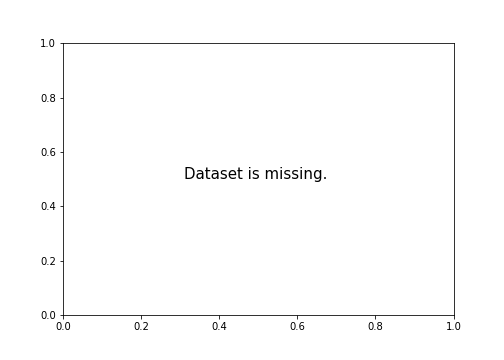

In [33]:
spp_checkpoint[0]

Ez egy ún. `MimickedDataset` objektum, amelyen megkötés nélkül módosíthatjuk az SPP-vel kapcsolatos adatokat. Az adatok változtatására továbbra is reagálni fog az `spp_checkpoint`:

In [35]:
spp_checkpoint.calculate(2, 3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [36]:
# egy adat megváltoztatása
spp_checkpoint[0].delay = -70

# újraszámolás már más adatokat ad
spp_checkpoint.calculate(2, 3);

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Egy ilyen `MimickedDataset` objektum visszakonvertálható igazi `Dataset` objektummá - amennyiben emlékszünk melyik interferogram fájlhoz tartozott. Ehhez használhatjuk a `to_dataset` függvényt.

In [37]:
mydataset = spp_checkpoint[0].to_dataset('-100.txt', parse=True, skiprows=8, meta_len=0, decimal=".", sep=",")


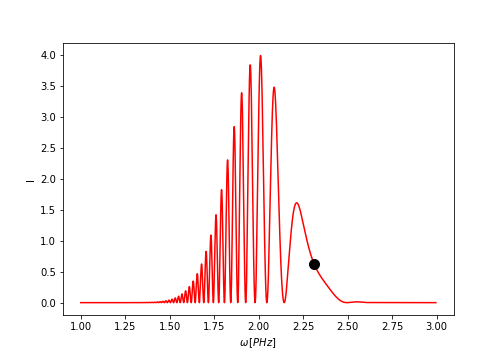

In [38]:
mydataset

Egy egyszerűbb módszer a betöltésre a `from_pattern` konstruktorral történik. Itt egy mintát kell megadnunk, amire a fájlnevek épülnek. Opcionálisan a `mod` argumentummal csoportosíthatjuk őket a megadott modulo szerint (általában a mod=3 lehet hasznos, ekkor ugyanis a karok spektrumaival könnyen csoportosíthatjuk a fájlokat.) Az általam generált fájlokhoz a `"*.txt"` mintát használom, illetve a betöltési opciók változatlanok:

In [44]:
spp2 = ps.SPPMethod.from_pattern('*.txt', skiprows=8, meta_len=0, decimal=".", sep="," )

In [45]:
spp2